In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

To start off with we need to obtain data from somewhere. In order to make things easy the pymks_share package is used to import data.

In [2]:
from pymks_share import DataManager

manager = DataManager('pymks.me.gatech.edu')
X, y  = manager.fetch_data('random hexagonal orientations')

print X.shape
print y.shape

(50L, 21L, 21L, 21L, 3L)
(50L, 21L, 21L, 21L)


The X variable contains a set of 3 Euler angles at each spatial point, corresponding to the crystal orientation. The y variable is the strain tensor in the x direction as obtained by a finite element simulation ($\epsilon_{xx}$). We can visualize this by plotting a microstructure ($\phi_1$ angle only) and the corresponding strain response.

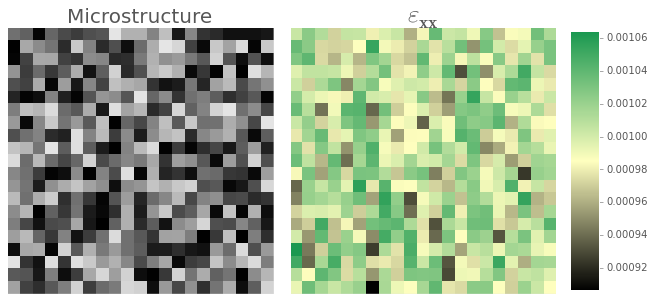

In [3]:
from pymks.tools import draw_microstructure_strain

n = X.shape[1]
center = (n-1) / 2
draw_microstructure_strain(X[0, :, :, center, 0], y[0, :, :,center])


This may not mean much, but trust us that the $\epsilon_{xx}$ field is rather expensive to calculate. In principle we could visualize this in 3 dimensions using a package like mayavi, but for this tutorial we will just look at a single slice down through the center.

In order to ensure that our models are valid, we need to split the data into "calibration" and "validation" sets. The idea here is that we train the model on a subset of N_calibrate datasets, then test the model on the rest. This is a crude form of "cross validation", and will give us confidence that we have not over-fit the model.

In [4]:
N_calibrate = 40
X_cal = X[0:N_calibrate, ...]
X_val = X[N_calibrate:, ...]
y_cal = y[0:N_calibrate, ...]
y_val = y[N_calibrate:, ...]
print X_cal.shape
print X_val.shape

(40L, 21L, 21L, 21L, 3L)
(10L, 21L, 21L, 21L, 3L)


We can see that we have 40 calibration sets, and 10 validation sets. Ideally we would have a lot more data to validate the model, but at least the 10 should give us an idea of how transferable the model is.

Next we need to set up the MKS "localization model" which will be used to compute all the parameters we need for the machine to "learn" how the input microstructure field is related to the output strain field. In order to capture the orientation dependence we are going to use a basis set of "generalized spherical harmonics". A quick Google search of "generalized spherical harmonics" will tell you that these are pretty nasty functions (nearly all the results are from technical journals!).

**TODO: Decide on syntax for GSH basis, and explain what all the arguments, etc mean**

In [22]:
from pymks import MKSLocalizationModel
from pymks.bases import GSHBasis
import pickle

gsh_hex_basis = GSHBasis(n_states=15, domain='hex')
model = MKSLocalizationModel(basis=gsh_hex_basis)

Now all of the complexity of the GSH basis set will be taken care of by pyMKS from here on out. We just need to fit the model:

In [23]:
model.fit(X_cal, y_cal)

and then we can look at the "influence coefficients" which capture the connection between the input and output fields. Notice that there are 15 influence coefficients, because we had 15 "states" in the basis set. In other words, there is a field of influence coefficients for each basis set. Again, we are only looking at a slice through the center in order to avoid the complexities of visualizing 3D data.

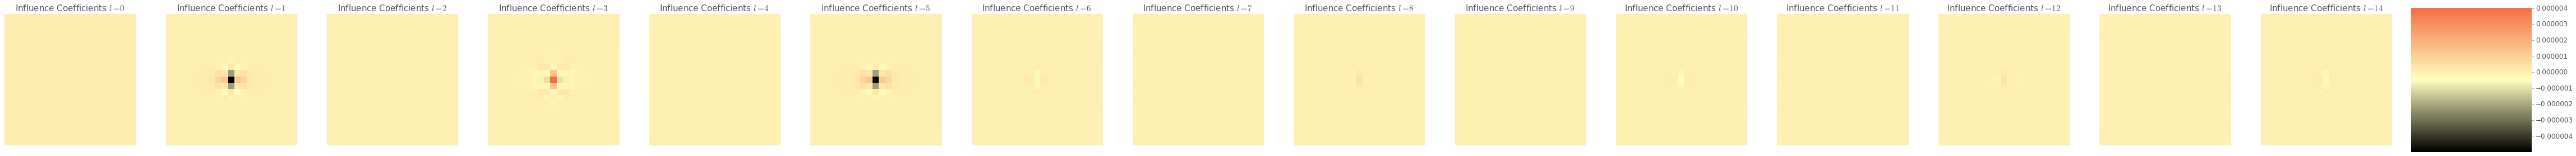

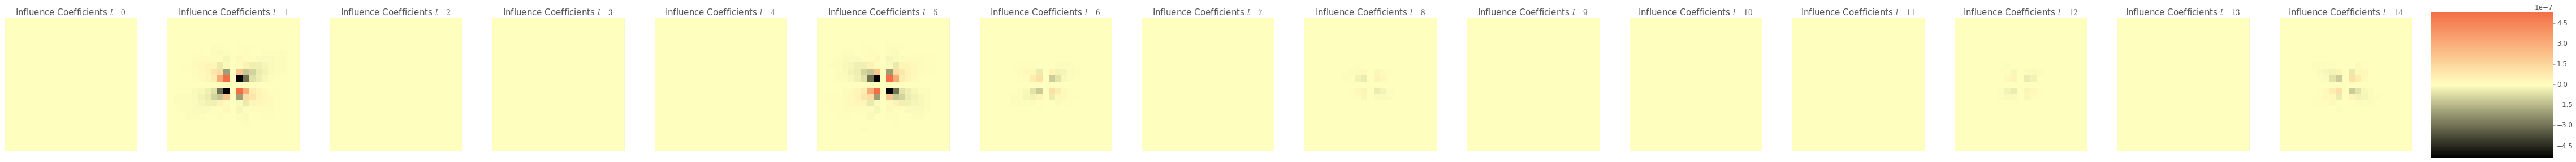

In [24]:
from pymks.tools import draw_coeff

coeff = model.coeff
draw_coeff(np.real(coeff[:,center, :, :]))
draw_coeff(np.imag(coeff[:,center, :, :]))

We can see that the coefficients for some basis sets have significant values, while others are mostly zero. This means that in principle we could probably describe the system with fewer basis states. We also notice that when there are non-zero components, they are typically centered near zero. This is intuitive, since it tells us that the elastic response of the material is local, as we would expect (and as can be seen in the other elasticity tutorials).

Finally, we want to use these coefficients to predict the response of the validation set, and ensure that the results are in line with the outputs of the full simulation.

In [25]:
y_predict = model.predict(X_val)

In [26]:
err = np.abs(y_predict - y_val)
print err.max(), err.mean()

9.5948464717e-06 1.46391816875e-06
